Problem Statement
add Codeadd Markdown
Topic Modeling for Research Articles 2.0 Researchers have access to large online archives of scientific articles. As a consequence, finding relevant articles has become more and more difficult. Tagging or topic modelling provides a way to give clear token of identification to research articles which facilitates recommendation and search process.

Earlier on the Independence Day we conducted a Hackathon to predict the topics for each article included in the test set. Continuing with the same problem, In this Live Hackathon we will take one more step ahead and predict the tags associated with the articles.

Given the abstracts for a set of research articles, predict the tags for each article included in the test set. Note that a research article can possibly have multiple tags. The research article abstracts are sourced from the following 4 topics:

Computer Science

Mathematics

Physics

Statistics

List of possible tags are as follows:

[Tags, Analysis of PDEs, Applications, Artificial Intelligence,Astrophysics of Galaxies, Computation and Language, Computer Vision and Pattern Recognition, Cosmology and Nongalactic Astrophysics, Data Structures and Algorithms, Differential Geometry, Earth and Planetary Astrophysics, Fluid Dynamics,Information Theory, Instrumentation and Methods for Astrophysics, Machine Learning, Materials Science, Methodology, Number Theory, Optimization and Control, Representation Theory, Robotics, Social and Information Networks, Statistics Theory, Strongly Correlated Electrons, Superconductivity, Systems and Control]

add Codeadd Markdown
image.png

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
import xgboost as xgb
import gc
from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
#from keras.layers.recurrent import LSTM, GRU
from keras.layers import LSTM, GRU
#from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Dense, Activation, Dropout
#from keras.layers.embeddings import Embedding
from keras.layers import Embedding
#from keras.layers.normalization import BatchNormalization
from keras.layers import BatchNormalization
#from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score,classification_report
from sklearn.model_selection import KFold, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB

from lightgbm import LGBMRegressor
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.simplefilter('ignore')
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

#stop_words = stopwords.words('english')
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

import seaborn as sns
import string
!pip install unidecode

import unidecode
import re
!pip install scikit-multilearn
from skmultilearn.problem_transform import LabelPowerset
#from skmultilearn.problem_transform import LabelPowerset# initialize label powerset multi-label classifier
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
train = pd.read_csv('/content//Train.csv')
test = pd.read_csv('/content//Test.csv')
ss = pd.read_csv('/content//sample_sub.csv')
tags = pd.read_csv('/content//Tags.csv')

Sample Submission File

In [ ]:
ss

,id,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,Computation and Language,Computer Vision and Pattern Recognition,Cosmology and Nongalactic Astrophysics,Data Structures and Algorithms,Differential Geometry,...,Methodology,Number Theory,Optimization and Control,Representation Theory,Robotics,Social and Information Networks,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control
0,9409,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,17934,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,16071,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,16870,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10496,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5997,11506,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5998,3418,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5999,7369,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6000,8421,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train

,id,ABSTRACT,Computer Science,Mathematics,Physics,Statistics,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,...,Methodology,Number Theory,Optimization and Control,Representation Theory,Robotics,Social and Information Networks,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control
0,1824,a ever-growing datasets inside observational a...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3094,we propose the framework considering optimal $...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8463,nanostructures with open shell transition meta...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2082,stars are self-gravitating fluids inside which...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8687,deep neural perception and control networks ar...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13999,8699,a methodology of automatic detection of a even...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
14000,11912,we consider a case inside which the robot has ...,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
14001,4842,despite being usually considered two competing...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
14002,12507,we present the framework and its implementatio...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
ss.describe()

,id,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,Computation and Language,Computer Vision and Pattern Recognition,Cosmology and Nongalactic Astrophysics,Data Structures and Algorithms,Differential Geometry,...,Methodology,Number Theory,Optimization and Control,Representation Theory,Robotics,Social and Information Networks,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control
count,6002.000000,6002.0,6002.0,6002.0,6002.0,6002.0,6002.0,6002.0,6002.0,6002.0,...,6002.0,6002.0,6002.0,6002.0,6002.0,6002.0,6002.0,6002.0,6002.0,6002.0
mean,9957.942852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,5764.170037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,4929.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,9952.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,14921.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,19999.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Exploratory Data Analysis
add Codeadd Markdown


1. Brief look at the dataset.

In [ ]:
train.head(3)
test.head(3)
tags.head(3)

,id,ABSTRACT,Computer Science,Mathematics,Physics,Statistics,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,...,Methodology,Number Theory,Optimization and Control,Representation Theory,Robotics,Social and Information Networks,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control
0,1824,a ever-growing datasets inside observational a...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3094,we propose the framework considering optimal $...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8463,nanostructures with open shell transition meta...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


,id,ABSTRACT,Computer Science,Mathematics,Physics,Statistics
0,9409,fundamental frequency (f0) approximation from ...,0,0,0,1
1,17934,"this large-scale study, consisting of 24.5 mil...",1,0,0,1
2,16071,we present a stability analysis of the plane c...,0,0,1,0


,Tags
0,Analysis of PDEs
1,Applications
2,Artificial Intelligence


In [ ]:
train.columns

Index(['id', 'ABSTRACT', 'Computer Science', 'Mathematics', 'Physics',
       'Statistics', 'Analysis of PDEs', 'Applications',
       'Artificial Intelligence', 'Astrophysics of Galaxies',
       'Computation and Language', 'Computer Vision and Pattern Recognition',
       'Cosmology and Nongalactic Astrophysics',
       'Data Structures and Algorithms', 'Differential Geometry',
       'Earth and Planetary Astrophysics', 'Fluid Dynamics',
       'Information Theory', 'Instrumentation and Methods for Astrophysics',
       'Machine Learning', 'Materials Science', 'Methodology', 'Number Theory',
       'Optimization and Control', 'Representation Theory', 'Robotics',
       'Social and Information Networks', 'Statistics Theory',
       'Strongly Correlated Electrons', 'Superconductivity',
       'Systems and Control'],
      dtype='object')

In [ ]:
ID_COL = 'id'

TARGET_COLS = ['Analysis of PDEs', 'Applications',
               'Artificial Intelligence', 'Astrophysics of Galaxies',
               'Computation and Language', 'Computer Vision and Pattern Recognition',
               'Cosmology and Nongalactic Astrophysics',
               'Data Structures and Algorithms', 'Differential Geometry',
               'Earth and Planetary Astrophysics', 'Fluid Dynamics',
               'Information Theory', 'Instrumentation and Methods for Astrophysics',
               'Machine Learning', 'Materials Science', 'Methodology', 'Number Theory',
               'Optimization and Control', 'Representation Theory', 'Robotics',
               'Social and Information Networks', 'Statistics Theory',
               'Strongly Correlated Electrons', 'Superconductivity',
               'Systems and Control']

TOPIC_COLS = ['Computer Science', 'Mathematics', 'Physics', 'Statistics']

In [ ]:
len(TARGET_COLS)

25

2. Dataset Shape (Number of Samples and Variables in the dataset)

In [ ]:
print(f'\n->->->| Train contains {train.shape[0]} samples and {train.shape[1]} variables')
print(f'\n->->->| Test contains {test.shape[0]} samples and {test.shape[1]} variables')
print(f'\n->->->| Number of distinct SUB TOPICS is {len(TARGET_COLS)}')

features = [c for c in train.columns if c not in [ID_COL] + TARGET_COLS]
print(TARGET_COLS)
print(train[TARGET_COLS])
print(features)
print(f'\n->->->| The dataset contains {len(features)} features')


->->->| Train contains 14004 samples and 31 variables

->->->| Test contains 6002 samples and 6 variables

->->->| Number of distinct SUB TOPICS is 25
['Analysis of PDEs', 'Applications', 'Artificial Intelligence', 'Astrophysics of Galaxies', 'Computation and Language', 'Computer Vision and Pattern Recognition', 'Cosmology and Nongalactic Astrophysics', 'Data Structures and Algorithms', 'Differential Geometry', 'Earth and Planetary Astrophysics', 'Fluid Dynamics', 'Information Theory', 'Instrumentation and Methods for Astrophysics', 'Machine Learning', 'Materials Science', 'Methodology', 'Number Theory', 'Optimization and Control', 'Representation Theory', 'Robotics', 'Social and Information Networks', 'Statistics Theory', 'Strongly Correlated Electrons', 'Superconductivity', 'Systems and Control']
       Analysis of PDEs  Applications  Artificial Intelligence  \
0                     0             0                        0   
1                     0             0                    

In [ ]:
train[TARGET_COLS].sum()

Analysis of PDEs                                 607
Applications                                     592
Artificial Intelligence                         1376
Astrophysics of Galaxies                         574
Computation and Language                         645
Computer Vision and Pattern Recognition          939
Cosmology and Nongalactic Astrophysics           633
Data Structures and Algorithms                   496
Differential Geometry                            555
Earth and Planetary Astrophysics                 504
Fluid Dynamics                                   364
Information Theory                               353
Instrumentation and Methods for Astrophysics     490
Machine Learning                                3825
Materials Science                                775
Methodology                                      574
Number Theory                                    398
Optimization and Control                         621
Representation Theory                         

3.Target Distribution

In [ ]:
100 * (train[TARGET_COLS].sum()/(train.shape[0])).sort_values(ascending=False)

Machine Learning                                27.313625
Artificial Intelligence                          9.825764
Robotics                                         6.812339
Computer Vision and Pattern Recognition          6.705227
Strongly Correlated Electrons                    6.376750
Materials Science                                5.534133
Computation and Language                         4.605827
Cosmology and Nongalactic Astrophysics           4.520137
Optimization and Control                         4.434447
Social and Information Networks                  4.420166
Analysis of PDEs                                 4.334476
Applications                                     4.227364
Astrophysics of Galaxies                         4.098829
Methodology                                      4.098829
Systems and Control                              4.041702
Differential Geometry                            3.963153
Superconductivity                                3.870323
Statistics The

4. Variable Datatypes
add Codeadd Markdown
Lets have a look at the kind of data types that is being used to store the variables in pandas.

pandas info() method on dataframe allows to do that. For each variable we can see the number of non-null values along with their datatypes.

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14004 entries, 0 to 14003
Data columns (total 31 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   id                                            14004 non-null  int64 
 1   ABSTRACT                                      14004 non-null  object
 2   Computer Science                              14004 non-null  int64 
 3   Mathematics                                   14004 non-null  int64 
 4   Physics                                       14004 non-null  int64 
 5   Statistics                                    14004 non-null  int64 
 6   Analysis of PDEs                              14004 non-null  int64 
 7   Applications                                  14004 non-null  int64 
 8   Artificial Intelligence                       14004 non-null  int64 
 9   Astrophysics of Galaxies                      14004 non-null  int64 
 10

5. Null Values
add Codeadd Markdown
Although the info() function did tell us about non-null values ideally we want to have a look at the percentage of null values in each variable.

In [ ]:
null_values_per_variable = 100 * (train.isnull().sum()/train.shape[0]).round(3)#.reset_index()
null_values_per_variable.sort_values(ascending=False)

id                                              0.0
Fluid Dynamics                                  0.0
Superconductivity                               0.0
Strongly Correlated Electrons                   0.0
Statistics Theory                               0.0
Social and Information Networks                 0.0
Robotics                                        0.0
Representation Theory                           0.0
Optimization and Control                        0.0
Number Theory                                   0.0
Methodology                                     0.0
Materials Science                               0.0
Machine Learning                                0.0
Instrumentation and Methods for Astrophysics    0.0
Information Theory                              0.0
Earth and Planetary Astrophysics                0.0
ABSTRACT                                        0.0
Differential Geometry                           0.0
Data Structures and Algorithms                  0.0
Cosmology an

6. Unique values in each variable

In [ ]:
train.nunique()

id                                              14004
ABSTRACT                                        14004
Computer Science                                    2
Mathematics                                         2
Physics                                             2
Statistics                                          2
Analysis of PDEs                                    2
Applications                                        2
Artificial Intelligence                             2
Astrophysics of Galaxies                            2
Computation and Language                            2
Computer Vision and Pattern Recognition             2
Cosmology and Nongalactic Astrophysics              2
Data Structures and Algorithms                      2
Differential Geometry                               2
Earth and Planetary Astrophysics                    2
Fluid Dynamics                                      2
Information Theory                                  2
Instrumentation and Methods 

ADDITIONAL DESCRIPTIVE EDA

In [ ]:
train[TOPIC_COLS].sum().sort_values(ascending=False)

Computer Science    5884
Physics             3856
Statistics          3794
Mathematics         2831
dtype: int64

In [ ]:
100 * (train[TARGET_COLS].sum()/(train.shape[0])).sort_values(ascending=False)

Machine Learning                                27.313625
Artificial Intelligence                          9.825764
Robotics                                         6.812339
Computer Vision and Pattern Recognition          6.705227
Strongly Correlated Electrons                    6.376750
Materials Science                                5.534133
Computation and Language                         4.605827
Cosmology and Nongalactic Astrophysics           4.520137
Optimization and Control                         4.434447
Social and Information Networks                  4.420166
Analysis of PDEs                                 4.334476
Applications                                     4.227364
Astrophysics of Galaxies                         4.098829
Methodology                                      4.098829
Systems and Control                              4.041702
Differential Geometry                            3.963153
Superconductivity                                3.870323
Statistics The

Visual Exploratory Data Analysis Through WordClouds

In [ ]:
from wordcloud import WordCloud, STOPWORDS

wc = WordCloud(stopwords = set(list(STOPWORDS) + ['inside']), random_state = 42)

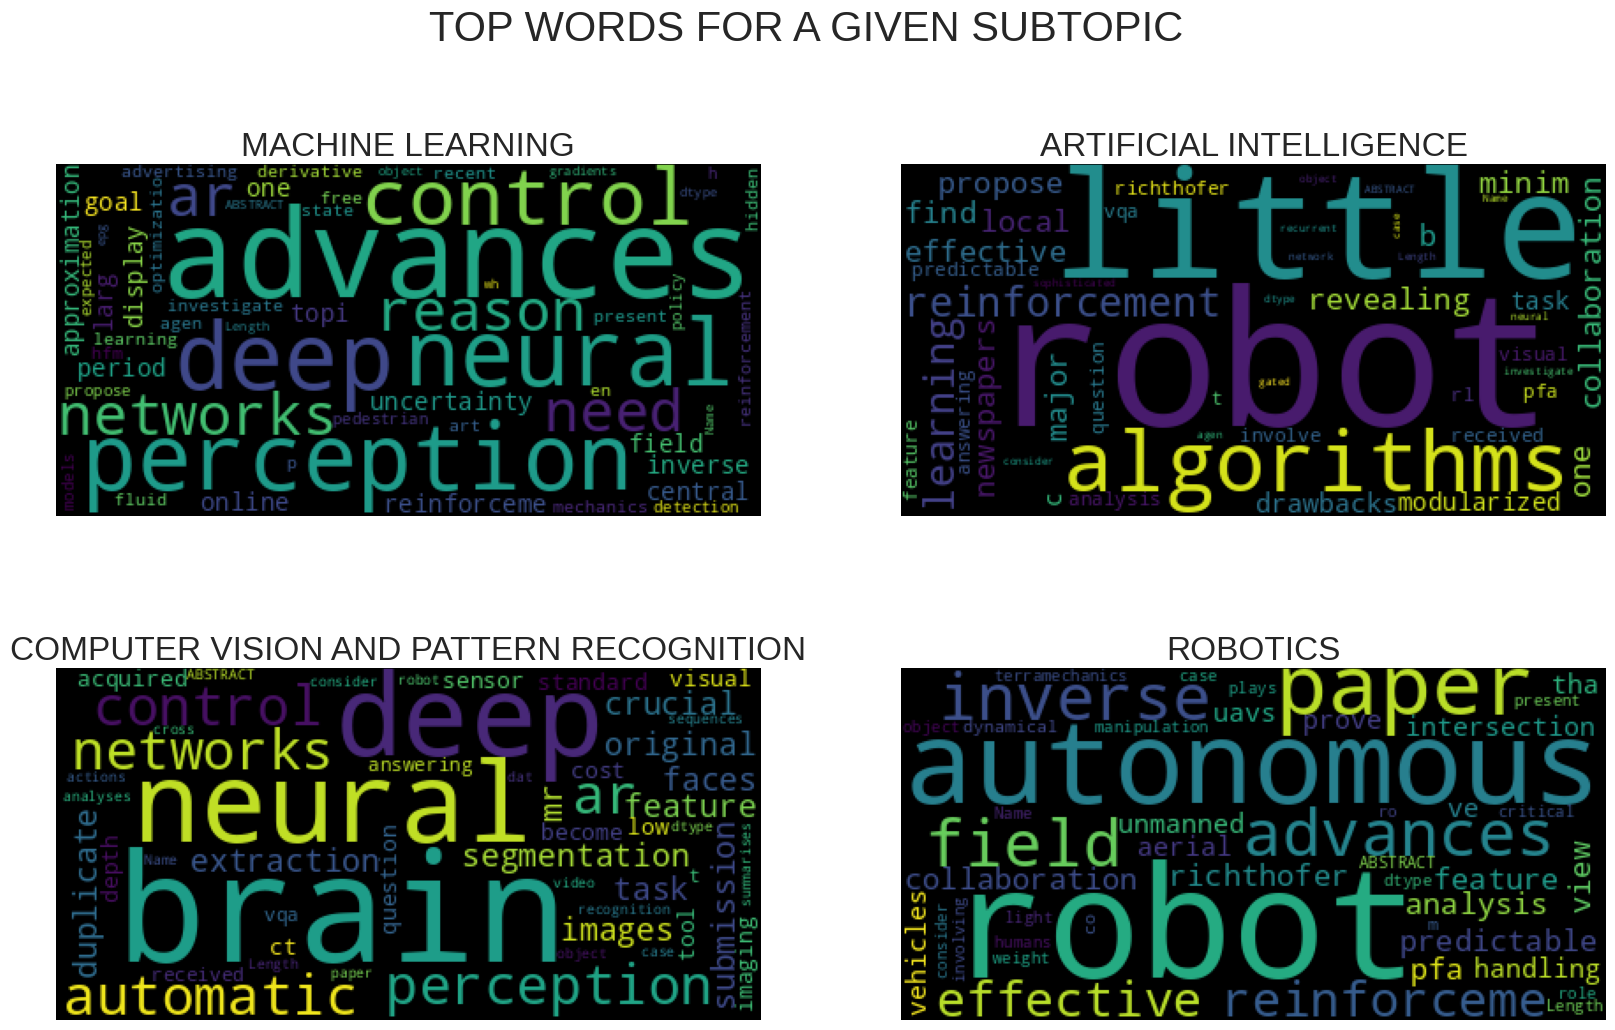

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = [ax for axes_row in axes for ax in axes_row]
for i, sub_topic_name in enumerate(['Machine Learning', 'Artificial Intelligence', 'Computer Vision and Pattern Recognition', 'Robotics']):
  sub_topic = train[train[sub_topic_name] == 1]
  op = wc.generate(str(sub_topic['ABSTRACT']))
  _ = axes[i].imshow(op)
  _ = axes[i].set_title(sub_topic_name.upper(), fontsize=24)
  _ = axes[i].axis('off')
_ = plt.suptitle('TOP WORDS FOR A GIVEN SUBTOPIC', fontsize=30)

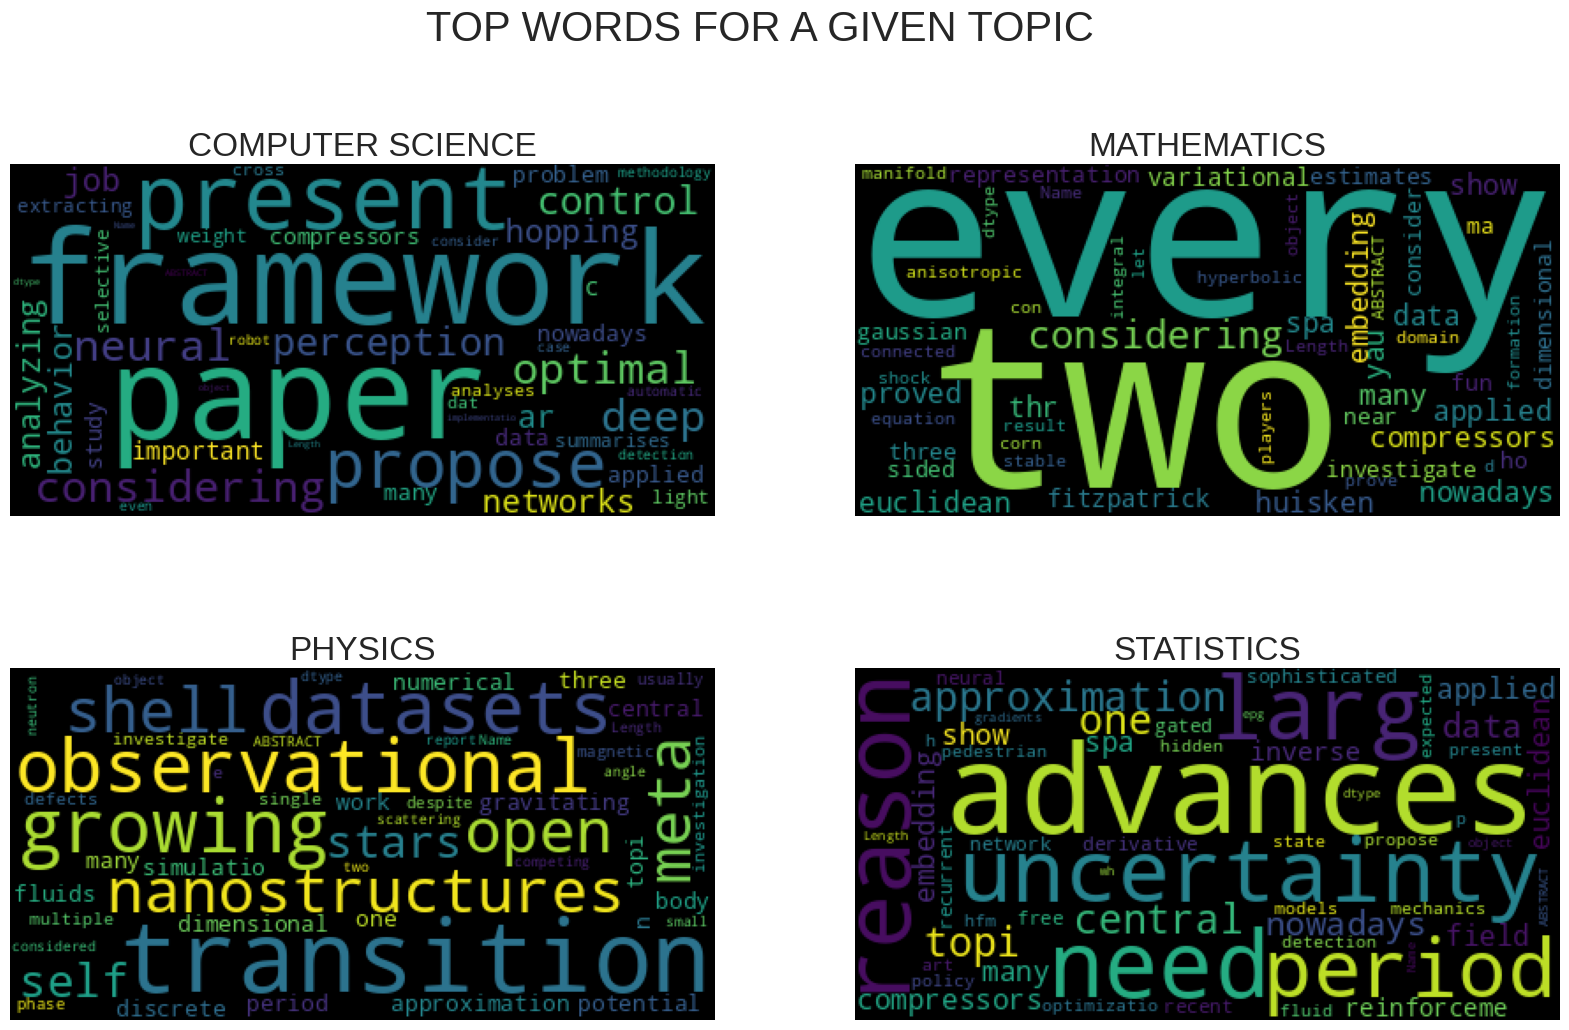

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = [ax for axes_row in axes for ax in axes_row]
for i, sub_topic_name in enumerate(TOPIC_COLS):
  sub_topic = train[train[sub_topic_name] == 1]
  op = wc.generate(str(sub_topic['ABSTRACT']))
  _ = axes[i].imshow(op)
  _ = axes[i].set_title(sub_topic_name.upper(), fontsize=24)
  _ = axes[i].axis('off')
_ = plt.suptitle('TOP WORDS FOR A GIVEN TOPIC', fontsize=30)

Model Building
add Codeadd Markdown
Bag of Words Approach
add Codeadd Markdown
Text: Collection of Words
Word: Adds some kind of meaning to the sentence.
We make a bag containing all the words in our dataset.
Features : How many times is a particular word from the bag is present in our sentence ?

Simple Example

In [ ]:
sent1 = 'Artificial Intelligence is the future'
sent2 = 'Analytics Vidhya is the best platform to learn Artificial Intelligence'
sent3 = 'To build a better future the way forward is to learn and improve constantly'

In [ ]:
all_sentences = [sent1, sent2, sent3]
all_words = [w for sent in all_sentences for w in sent.split()]
all_words = list(set(all_words))
all_words

['to',
 'future',
 'way',
 'is',
 'Artificial',
 'learn',
 'best',
 'a',
 'the',
 'build',
 'To',
 'Intelligence',
 'improve',
 'platform',
 'constantly',
 'better',
 'Vidhya',
 'Analytics',
 'and',
 'forward']

In [ ]:
columns = {word: [] for word in all_words}
for word in all_words:
  for sent in all_sentences:
    sent_words = sent.split()
    count = sum([(word==w) for w in sent_words])
    columns[word].append(count)

In [ ]:
sent1 = 'Artificial Intelligence is the future '
sent2 = 'Analytics Vidhya is the best platform to learn Artificial Intelligence'
sent3 = 'To build a better future the way forward is to learn and improve constantly'

In [ ]:
counts = pd.DataFrame(columns)

In [ ]:
counts

,to,future,way,is,Artificial,learn,best,a,the,build,To,Intelligence,improve,platform,constantly,better,Vidhya,Analytics,and,forward
0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,1,1,1,1,0,1,0,0,1,0,1,0,0,1,1,0,0
2,1,1,1,1,0,1,0,1,1,1,1,0,1,0,1,1,0,0,1,1


Count Vectorizer

In [ ]:
vec = CountVectorizer(max_features=10000)
combined = list(train['ABSTRACT']) + list(test['ABSTRACT'])
vec.fit(combined)

CountVectorizer(max_features=10000)

In [ ]:
trn, val = train_test_split(train, test_size=0.2, random_state=2)

In [ ]:
trn_abs = vec.transform(trn['ABSTRACT'])
val_abs = vec.transform(val['ABSTRACT'])
tst_abs = vec.transform(test['ABSTRACT'])

In [ ]:
trn[TARGET_COLS]

,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,Computation and Language,Computer Vision and Pattern Recognition,Cosmology and Nongalactic Astrophysics,Data Structures and Algorithms,Differential Geometry,Earth and Planetary Astrophysics,...,Methodology,Number Theory,Optimization and Control,Representation Theory,Robotics,Social and Information Networks,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control
6036,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6168,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5724,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2836,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
11745,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11798,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13896,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6637,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2575,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
clf = OneVsRestClassifier(LogisticRegression(C = 10, n_jobs=-1))
clf.fit(trn_abs, trn[TARGET_COLS])

OneVsRestClassifier(estimator=LogisticRegression(C=10, n_jobs=-1))

In [ ]:
val_preds = clf.predict(val_abs)
f1_score(val[TARGET_COLS], val_preds, average='micro')

0.6227994227994228

In [ ]:
preds_test = clf.predict(tst_abs)

In [ ]:
def download_preds(preds_test, file_name = 'hacklive_sub.csv'):

  ## 1. Setting the target column with our obtained predictions
  ss[TARGET_COLS] = preds_test

  ## 2. Saving our predictions to a csv file

  ss.to_csv(file_name, index = False)

In [ ]:
download_preds(preds_test, 'hacklive_NLP_count.csv')

Tfidf Vectorizer

In [ ]:
counts

,to,future,way,is,Artificial,learn,best,a,the,build,To,Intelligence,improve,platform,constantly,better,Vidhya,Analytics,and,forward
0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,1,1,1,1,0,1,0,0,1,0,1,0,0,1,1,0,0
2,1,1,1,1,0,1,0,1,1,1,1,0,1,0,1,1,0,0,1,1


TF-IDF = Term-Frequency * Inverse Document Frequency

Term-Frequency = (Frequency of the word in the sentence) / (Total number of words in the sentence)

Inverse Document Frequency = (Total number of sentences)/(Number of sentences containing the word)

add Codeadd Markdown
Simple Example

In [ ]:
sent1 = 'Artificial Intelligence is the future'
sent2 = 'Analytics Vidhya is the best platform to learn Artificial Intelligence'
sent3 = 'To build a better future the way forward is to learn and improve constantly'

In [ ]:
term_frequency = counts.copy()
term_frequency = term_frequency.apply(lambda x: x/term_frequency.sum(axis = 1))
term_frequency

,to,future,way,is,Artificial,learn,best,a,the,build,To,Intelligence,improve,platform,constantly,better,Vidhya,Analytics,and,forward
0,0.000000,0.200000,0.000000,0.200000,0.2,0.000000,0.0,0.000000,0.200000,0.000000,0.000000,0.2,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,0.100000,0.000000,0.000000,0.100000,0.1,0.100000,0.1,0.000000,0.100000,0.000000,0.000000,0.1,0.000000,0.1,0.000000,0.000000,0.1,0.1,0.000000,0.000000
2,0.071429,0.071429,0.071429,0.071429,0.0,0.071429,0.0,0.071429,0.071429,0.071429,0.071429,0.0,0.071429,0.0,0.071429,0.071429,0.0,0.0,0.071429,0.071429


In [ ]:
inverse_document_frequency = counts.copy()
inverse_document_frequency = inverse_document_frequency.apply(lambda x: 3/(x > 0).sum())
inverse_document_frequency

to              1.5
future          1.5
way             3.0
is              1.0
Artificial      1.5
learn           1.5
best            3.0
a               3.0
the             1.0
build           3.0
To              3.0
Intelligence    1.5
improve         3.0
platform        3.0
constantly      3.0
better          3.0
Vidhya          3.0
Analytics       3.0
and             3.0
forward         3.0
dtype: float64

In [ ]:
tfidf = term_frequency * inverse_document_frequency
tfidf

,to,future,way,is,Artificial,learn,best,a,the,build,To,Intelligence,improve,platform,constantly,better,Vidhya,Analytics,and,forward
0,0.000000,0.300000,0.000000,0.200000,0.30,0.000000,0.0,0.000000,0.200000,0.000000,0.000000,0.30,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1,0.150000,0.000000,0.000000,0.100000,0.15,0.150000,0.3,0.000000,0.100000,0.000000,0.000000,0.15,0.000000,0.3,0.000000,0.000000,0.3,0.3,0.000000,0.000000
2,0.107143,0.107143,0.214286,0.071429,0.00,0.107143,0.0,0.214286,0.071429,0.214286,0.214286,0.00,0.214286,0.0,0.214286,0.214286,0.0,0.0,0.214286,0.214286


In [ ]:
vec = TfidfVectorizer(max_features=10000)
_ = vec.fit(list(train['ABSTRACT']) + list(test['ABSTRACT']))

trn_abs = vec.transform(trn['ABSTRACT'])
val_abs = vec.transform(val['ABSTRACT'])
tst_abs = vec.transform(test['ABSTRACT'])

clf = OneVsRestClassifier(LogisticRegression(C = 10, n_jobs=-1))
_ = clf.fit(trn_abs, trn[TARGET_COLS])

val_preds = clf.predict(val_abs)
f1_score(val[TARGET_COLS], val_preds, average='micro')

0.6300845429893125

In [ ]:
preds_test = clf.predict(tst_abs)
download_preds(preds_test, 'hacklive_NLP_tfidf.csv')

In [ ]:
def get_best_thresholds(true, preds):
  thresholds = [i/100 for i in range(100)]
  best_thresholds = []
  for idx in range(25):
    f1_scores = [f1_score(true[:, idx], (preds[:, idx] > thresh) * 1) for thresh in thresholds]
    print(f1_scores)
    best_thresh = thresholds[np.argmax(f1_scores)]
    best_thresholds.append(best_thresh)
    print(best_thresholds)
  return best_thresholds

In [ ]:
val_preds = clf.predict_proba(val_abs)

best_thresholds = get_best_thresholds(val[TARGET_COLS].values, val_preds)

for i, thresh in enumerate(best_thresholds):
  val_preds[:, i] = (val_preds[:, i] > thresh) * 1

f1_score(val[TARGET_COLS], val_preds, average='micro')

[0.0841313269493844, 0.35640648011782033, 0.4817813765182187, 0.5424528301886792, 0.6068601583113455, 0.6436781609195402, 0.6666666666666666, 0.6772151898734177, 0.7062706270627063, 0.7109634551495017, 0.7098976109215017, 0.7152777777777778, 0.7214285714285714, 0.7080291970802919, 0.7185185185185183, 0.7245283018867924, 0.7224334600760456, 0.7279693486590038, 0.7315175097276265, 0.734375, 0.7193675889328062, 0.7250996015936255, 0.7250996015936255, 0.7287449392712552, 0.7287449392712552, 0.726530612244898, 0.7242798353909464, 0.7272727272727273, 0.7333333333333334, 0.7203389830508473, 0.7264957264957265, 0.7296137339055793, 0.7280701754385964, 0.7288888888888888, 0.7232142857142858, 0.7232142857142858, 0.7232142857142858, 0.7174887892376682, 0.7174887892376682, 0.7090909090909092, 0.7123287671232876, 0.7096774193548387, 0.7037037037037038, 0.7069767441860465, 0.7042253521126761, 0.7042253521126761, 0.6981132075471698, 0.6981132075471698, 0.6857142857142856, 0.6794258373205743, 0.6730769

0.6872952311612669

In [ ]:
preds_test = clf.predict_proba(tst_abs)

for i, thresh in enumerate(best_thresholds):
  preds_test[:, i] = (preds_test[:, i] > thresh) * 1

download_preds(preds_test, 'hacklive_NLP_tfidf_threshold_optimized.csv')

In [ ]:
TOPIC_COLS

['Computer Science', 'Mathematics', 'Physics', 'Statistics']

Combining Topics

In [ ]:
trn_abs.shape

(11203, 10000)

In [ ]:
vec = CountVectorizer(max_features=10000)
_ = vec.fit(list(train['ABSTRACT']) + list(test['ABSTRACT']))

trn_abs = vec.transform(trn['ABSTRACT'])
val_abs = vec.transform(val['ABSTRACT'])
tst_abs = vec.transform(test['ABSTRACT'])
print(trn_abs.shape, val_abs.shape, tst_abs.shape)

trn2 = np.hstack((trn_abs.toarray(), trn[TOPIC_COLS]))
val2 = np.hstack((val_abs.toarray(), val[TOPIC_COLS]))
tst2 = np.hstack((tst_abs.toarray(), test[TOPIC_COLS]))

print(trn2.shape, val2.shape, tst2.shape)

(11203, 10000) (2801, 10000) (6002, 10000)
(11203, 10004) (2801, 10004) (6002, 10004)


In [ ]:
from scipy.sparse import csr_matrix

trn2 = csr_matrix(trn2.astype('int16'))
val2 = csr_matrix(val2.astype('int16'))
tst2 = csr_matrix(tst2.astype('int16'))

In [ ]:
clf = OneVsRestClassifier(LogisticRegression(C = 10, n_jobs=-1))
_  = clf.fit(trn2, trn[TARGET_COLS])

val_preds = clf.predict_proba(val2)
best_thresholds = get_best_thresholds(val[TARGET_COLS].values, val_preds)

for i, thresh in enumerate(best_thresholds):
  val_preds[:, i] = (val_preds[:, i] > thresh) * 1
  print(i, thresh)

f1_score(val[TARGET_COLS], val_preds, average='micro')

0 0.49
1 0.04
2 0.01
3 0.07
4 0.16
5 0.15
6 0.11
7 0.03
8 0.27
9 0.07
10 0.18
11 0.06
12 0.26
13 0.27
14 0.47
15 0.01
16 0.21
17 0.09
18 0.26
19 0.09
20 0.13
21 0.36
22 0.04
23 0.2
24 0.14


0.7116730084693752

In [ ]:
preds_test = clf.predict_proba(tst2)

for i, thresh in enumerate(best_thresholds):
  preds_test[:, i] = (preds_test[:, i] > thresh) * 1

download_preds(preds_test, 'hacklive_NLP_count_added_topics.csv')

What more can you do ?

Hyperparameter tuning (Refer earlier Hacklive Sessions).
n-gram models instead of 1 gram models. Try 2-gram models, 3-gram models.
Text Cleaning.
add Codeadd Markdown


Word Embeddings
Problems with BOW approach.

In [ ]:
train['text'] = ' '
test['text'] = ' '


train['text'] += train['ABSTRACT']
test['text'] += test['ABSTRACT']

trn, val = train_test_split(train, test_size=0.2, random_state=2)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tok = Tokenizer(num_words = 1000000)
tok.fit_on_texts(train['text'].str.lower().tolist() + test['text'].str.lower().tolist())

vocab_size = len(tok.word_index) + 1

In [ ]:
X_trn = tok.texts_to_sequences(trn['text'])
X_val = tok.texts_to_sequences(val['text'])
X_test = tok.texts_to_sequences(test['text'])

In [ ]:
maxlen = 200
X_trn = pad_sequences(X_trn, maxlen=maxlen)
X_val = pad_sequences(X_val, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, SpatialDropout1D, LSTM


embedding_dim = 50
vocab_size = len(tok.word_index) + 1

model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=maxlen))

model.add(Flatten())
model.add(Dense(200, activation='relu', name = 'Fully_Connected'))
model.add(Dense(25, activation='sigmoid', name = 'Output'))
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'],
              )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 50)           2583250   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 Fully_Connected (Dense)     (None, 200)               2000200   
                                                                 
 Output (Dense)              (None, 25)                5025      
                                                                 
Total params: 4588475 (17.50 MB)
Trainable params: 4588475 (17.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Model Architecture

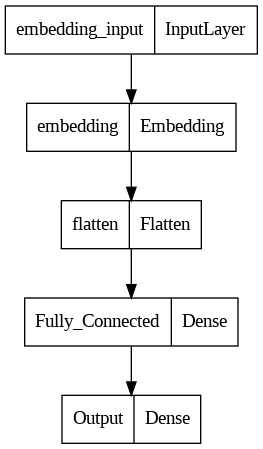

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
model.fit(X_trn, trn[TARGET_COLS], validation_data=(X_val, val[TARGET_COLS]), verbose=True, epochs=30, batch_size=256,
          callbacks = [tf.keras.callbacks.ReduceLROnPlateau()])

Epoch 1/30
44/44 [==============================] - 10s 166ms/step - loss: 0.2748 - accuracy: 0.1444 - val_loss: 0.1925 - val_accuracy: 0.1649 - lr: 0.0010
Epoch 2/30
44/44 [==============================] - 7s 158ms/step - loss: 0.1777 - accuracy: 0.2170 - val_loss: 0.1673 - val_accuracy: 0.2567 - lr: 0.0010
Epoch 3/30
44/44 [==============================] - 5s 117ms/step - loss: 0.1476 - accuracy: 0.3331 - val_loss: 0.1497 - val_accuracy: 0.3106 - lr: 0.0010
Epoch 4/30
44/44 [==============================] - 5s 103ms/step - loss: 0.1226 - accuracy: 0.4379 - val_loss: 0.1366 - val_accuracy: 0.3556 - lr: 0.0010
Epoch 5/30
44/44 [==============================] - 4s 101ms/step - loss: 0.0959 - accuracy: 0.5986 - val_loss: 0.1263 - val_accuracy: 0.4127 - lr: 0.0010
Epoch 6/30
44/44 [==============================] - 3s 75ms/step - loss: 0.0677 - accuracy: 0.7332 - val_loss: 0.1190 - val_accuracy: 0.4773 - lr: 0.0010
Epoch 7/30
44/44 [==============================] - 4s 86ms/step - los

In [ ]:
def get_best_thresholds(true, preds):
  thresholds = [i/100 for i in range(100)]
  best_thresholds = []
  for idx in range(25):
    f1_scores = [f1_score(true[:, idx], (preds[:, idx] > thresh) * 1) for thresh in thresholds]
    best_thresh = thresholds[np.argmax(f1_scores)]
    best_thresholds.append(best_thresh)
  return best_thresholds

val_preds = model.predict(X_val)
best_thresholds = get_best_thresholds(val[TARGET_COLS].values, val_preds)
for i, thresh in enumerate(best_thresholds):
  val_preds[:, i] = (val_preds[:, i] > thresh) * 1
f1_score(val[TARGET_COLS], val_preds, average='micro')

88/88 [==============================] - 0s 3ms/step


0.5821528030027848

In [ ]:
preds_test = model.predict(X_test)

for i, thresh in enumerate(best_thresholds):
  preds_test[:, i] = (preds_test[:, i] > thresh) * 1

download_preds(preds_test, 'hacklive_NLP_word_embeddings.csv')

188/188 [==============================] - 0s 1ms/step


In [ ]:
X_trn.shape
trn[TARGET_COLS].shape
X_val.shape
val[TARGET_COLS].shape

(11203, 200)

(11203, 25)

(2801, 200)

(2801, 25)

Ideas to progress further !!!
Try pretrained word embeddings.
Try using LSTMs instead of simple fully connected layers.
Try using SOTA Models.
Ensembling ? Can we combine all these models ?
Useful Links
add Codeadd Markdown
https://huggingface.co/transformers

https://github.com/ThilinaRajapakse/simpletransformers

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout


# Define LSTM model
# Example model architecture
model = Sequential()
model.add(Dense(64, input_shape=(200,)))  # Example input_shape
model.add(Activation('relu'))
model.add(Dense(25))  # This layer should match the output shape of the previous layer
model.add(Activation('relu'))
model.add(Dense(25, activation='softmax'))  # Adjust units and activation for your task

# Compile the model with appropriate loss and metrics
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_trn, trn[TARGET_COLS], validation_data=(X_val, val[TARGET_COLS]), epochs=20, batch_size=256)


preds_test = model.predict(X_test)

for i, thresh in enumerate(best_thresholds):
  preds_test[:, i] = (preds_test[:, i] > thresh) * 1

download_preds(preds_test, 'hacklive_NLP_word_embeddings.csv')

Epoch 1/20
44/44 [==============================] - 2s 14ms/step - loss: 3161.7261 - accuracy: 0.0498 - val_loss: 775.2467 - val_accuracy: 0.0425
Epoch 2/20
44/44 [==============================] - 0s 9ms/step - loss: 243.3979 - accuracy: 0.0947 - val_loss: 50.4297 - val_accuracy: 0.1489
Epoch 3/20
44/44 [==============================] - 1s 17ms/step - loss: 30.1506 - accuracy: 0.1632 - val_loss: 19.3088 - val_accuracy: 0.1560
Epoch 4/20
44/44 [==============================] - 1s 17ms/step - loss: 14.9385 - accuracy: 0.1690 - val_loss: 12.1913 - val_accuracy: 0.1599
Epoch 5/20
44/44 [==============================] - 1s 13ms/step - loss: 9.8616 - accuracy: 0.1704 - val_loss: 9.3581 - val_accuracy: 0.1603
Epoch 6/20
44/44 [==============================] - 0s 8ms/step - loss: 7.6151 - accuracy: 0.1708 - val_loss: 8.3715 - val_accuracy: 0.1614
Epoch 7/20
44/44 [==============================] - 0s 8ms/step - loss: 6.4155 - accuracy: 0.1717 - val_loss: 7.8507 - val_accuracy: 0.1617
Epoc

KeyError: "None of [Index(['Analysis of PDEs', 'Applications', 'Artificial Intelligence',\n       'Astrophysics of Galaxies', 'Computation and Language',\n       'Computer Vision and Pattern Recognition',\n       'Cosmology and Nongalactic Astrophysics',\n       'Data Structures and Algorithms', 'Differential Geometry',\n       'Earth and Planetary Astrophysics', 'Fluid Dynamics',\n       'Information Theory', 'Instrumentation and Methods for Astrophysics',\n       'Machine Learning', 'Materials Science', 'Methodology', 'Number Theory',\n       'Optimization and Control', 'Representation Theory', 'Robotics',\n       'Social and Information Networks', 'Statistics Theory',\n       'Strongly Correlated Electrons', 'Superconductivity',\n       'Systems and Control'],\n      dtype='object')] are in the [columns]"